# <b><u> Project Title : Topic Modelling using Latent Dirichilet Analysis (News Classification) </u></b>

## <b> Introduction </b>
Topic modelling is an approach to discover abstract topics present in a corpus of text documents using Natural Language Processing(NLP) and Clustering techniques.

The dataset consists of a collection of news articles from BBC News which belong one of five topics, business, entertainment, politics, sports and technology. The objective is to build an unsupervised machine learning model to identify hidden topics from news articles.

The procedure to complete this task starts from data preprocessing where all the text documents are aggregated from different topics to create a single dataset and duplicates are removed, data exploration, data cleaning such as removal of stop-words, short-length words, special characters and other unnecessary elements from texts, Lemmatization to reduce words to their root form, Vectorization and finally modelling using clustering algorithms such as Latent Dirichlet Allocation(LDA) and Latent Semantic Analysis(LSA).

## <b> Problem Description </b>

In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [ ]:
#importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import re
import nltk
from nltk.tokenize import RegexpTokenizer

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
import gensim
from wordcloud import WordCloud
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#!pip install pyLDAvis
import pyLDAvis
pyLDAvis.enable_notebook()

### Loading dataset

In [ ]:
#mouting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loading the data
News=[]
Type=[]

path="/content/drive/MyDrive/Colab Notebooks/Topic Modelling Project/Topic Modeling on News Articles/bbc"
folders=["business","entertainment","politics","sport","tech"]
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)


In [ ]:
#writing data to csv format
data={'news':News,'type':Type}
df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Topic Modelling Project/Topic Modeling on News Articles/bbc.csv')

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Topic Modelling Project/Topic Modeling on News Articles/bbc.csv')

### Data overview

In [ ]:
df.head()

,Unnamed: 0,news,type
0,0,b'Industrial output falls in Japan\n\nJapanese...,business
1,1,b'Umbro profits lifted by Euro 2004\n\nUK spor...,business
2,2,"b""Chinese wine tempts Italy's Illva\n\nItaly's...",business
3,3,b'Deutsche Telekom sees mobile gain\n\nGerman ...,business
4,4,b'Japanese mogul arrested for fraud\n\nOne of ...,business


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2225 non-null   int64 
 1   news        2225 non-null   object
 2   type        2225 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.3+ KB


In [ ]:
#Shape of dataframe
df.shape

(2225, 3)

In [ ]:
#descriprtion of object data type
df.describe(include='object')

,news,type
count,2225,2225
unique,2127,5
top,b'Millions buy MP3 players in US\n\nOne in 10 ...,sport
freq,2,511


In [ ]:
#removing duplicates
print(len(df[df['news'].duplicated()]))
df=df.drop_duplicates('news')

98


In [ ]:
#new shape of data frame
df.shape

(2127, 3)

In [ ]:
#dropping the index column of the dataset
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
#different type of articles
print(df.type.unique())

['business' 'entertainment' 'politics' 'sport' 'tech']


In [ ]:
df.head()

,news,type
0,b'Industrial output falls in Japan\n\nJapanese...,business
1,b'Umbro profits lifted by Euro 2004\n\nUK spor...,business
2,"b""Chinese wine tempts Italy's Illva\n\nItaly's...",business
3,b'Deutsche Telekom sees mobile gain\n\nGerman ...,business
4,b'Japanese mogul arrested for fraud\n\nOne of ...,business


* The dataset consist of 2225 rows and 3 columns (unique_id,news,type)
* The news articles are of 5 unique types.
* The dataset has no null values but it has 98 duplicate news articles.
* The new shape of the dataset is 2127 rows with 3 columns after removal of duplicates

### Feature engineering

In [ ]:
#length of the news
df['length']=df.news.str.len()

In [ ]:
#function to count the number of words in the article
def word_count(article):
  return len(article.split(" "))

In [ ]:
# Getting word count of each article
df['word_count']=df['news'].apply(word_count)

In [ ]:
#Description of these new variable
df.describe()

,length,word_count
count,2127.000000,2127.000000
mean,2288.551951,379.444758
std,1393.870831,238.261401
min,512.000000,87.000000
25%,1460.000000,242.000000
50%,1987.000000,327.000000
75%,2825.500000,465.000000
max,25670.000000,4377.000000


In [ ]:
#Total number of words present in the whole corpus
Total_words=sum(df['word_count'])
Total_words

807079

In [ ]:
# Percentage of Types of news in the dataset
df['type'].value_counts(normalize=True)*100

type
sport            23.742360
business         23.648331
politics         18.946874
entertainment    17.348378
tech             16.314057
Name: proportion, dtype: float64

[Text(0.5, 1.0, 'Count of different types of news articles')]

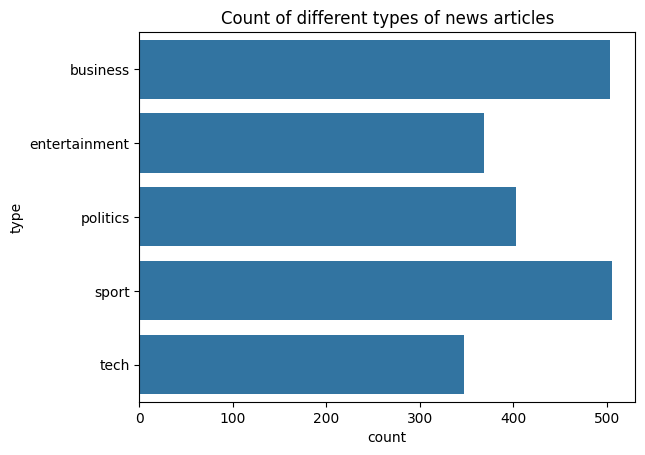

In [ ]:
#Countplot of different types of Articles in the dataset
sns.countplot(df['type']).set(title='Count of different types of news articles')

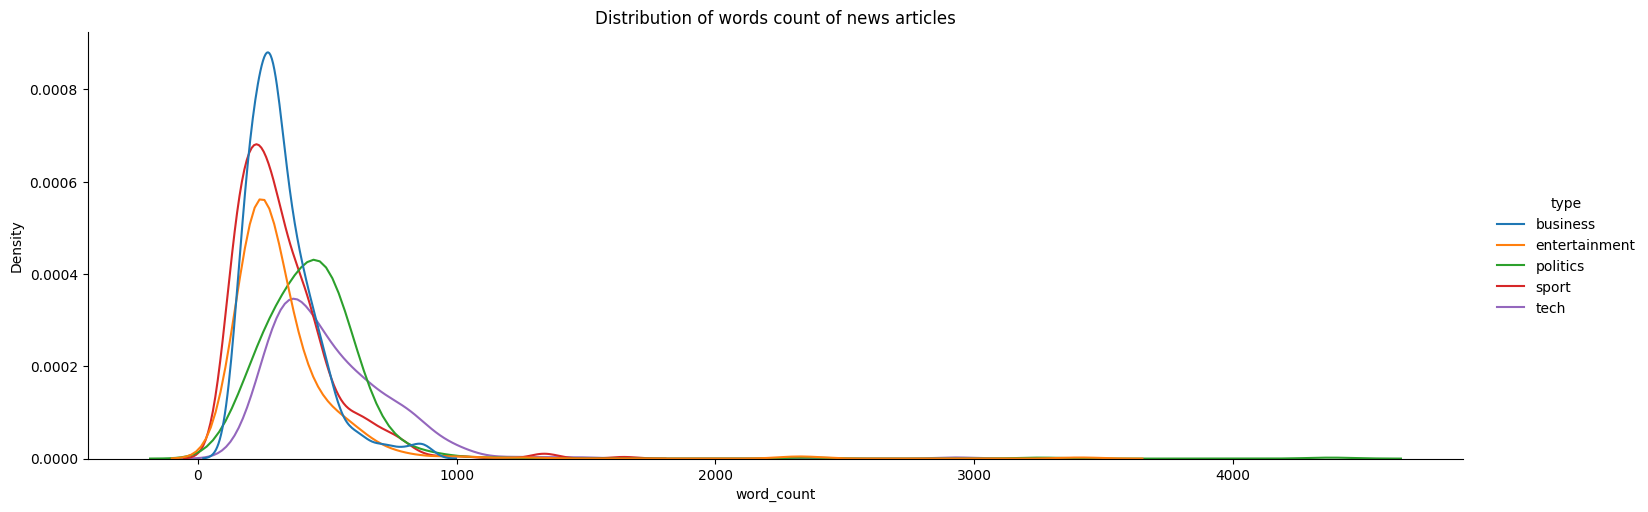

In [ ]:
#distribution of word counts of different news type
sns.displot(df, x="word_count", hue="type", kind="kde",height=5,aspect =3 ).set(title='Distribution of words count of news articles')

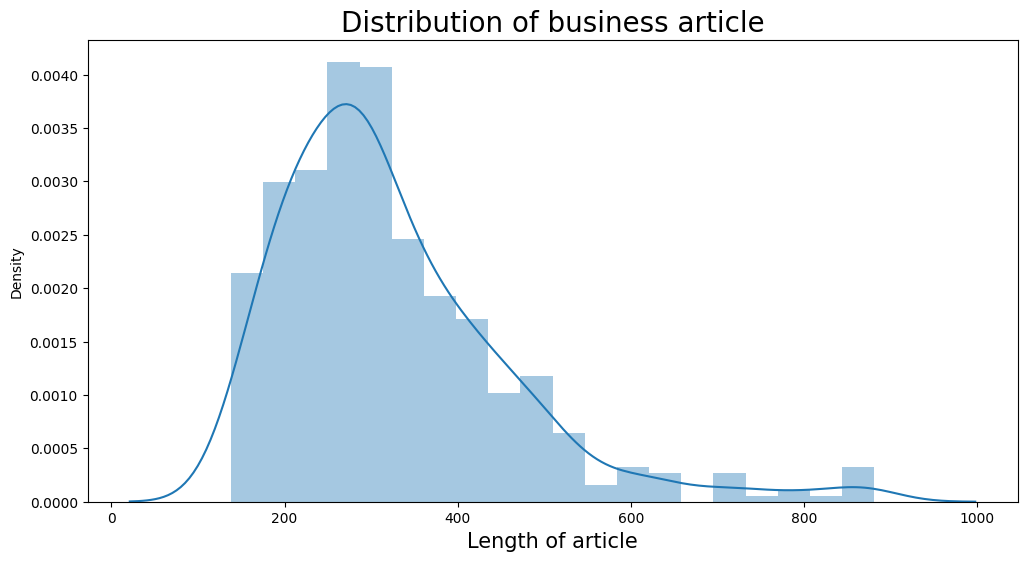

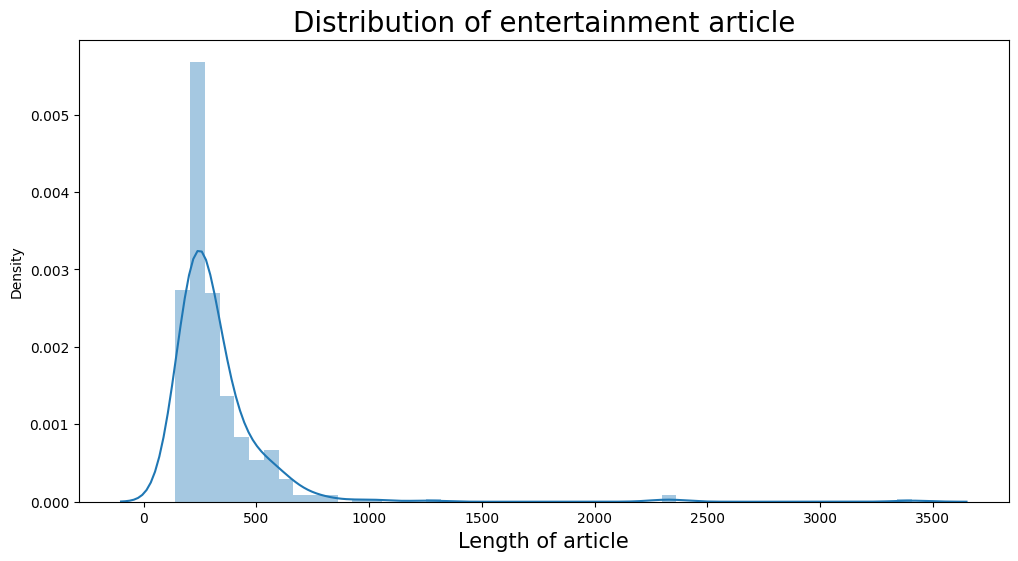

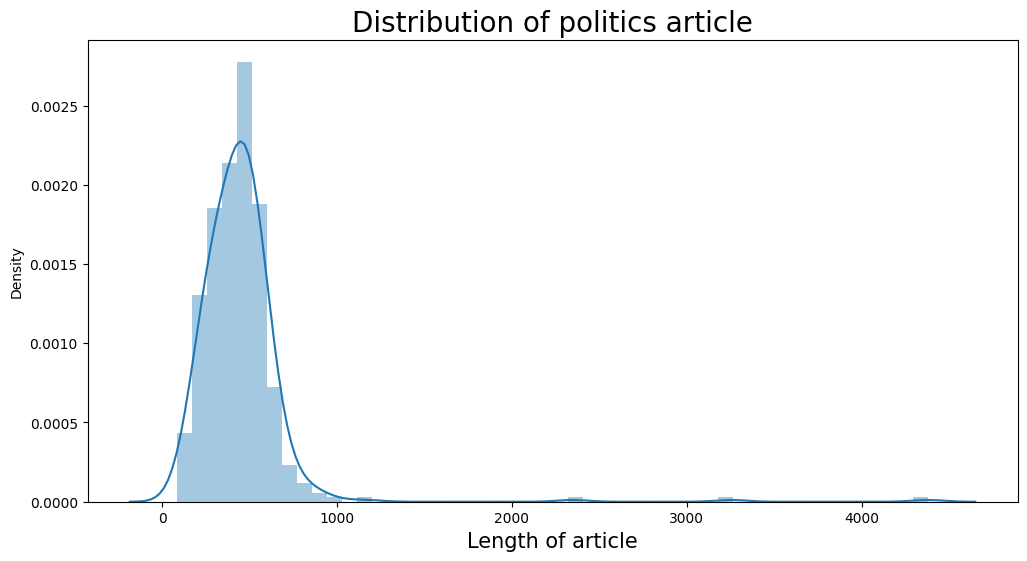

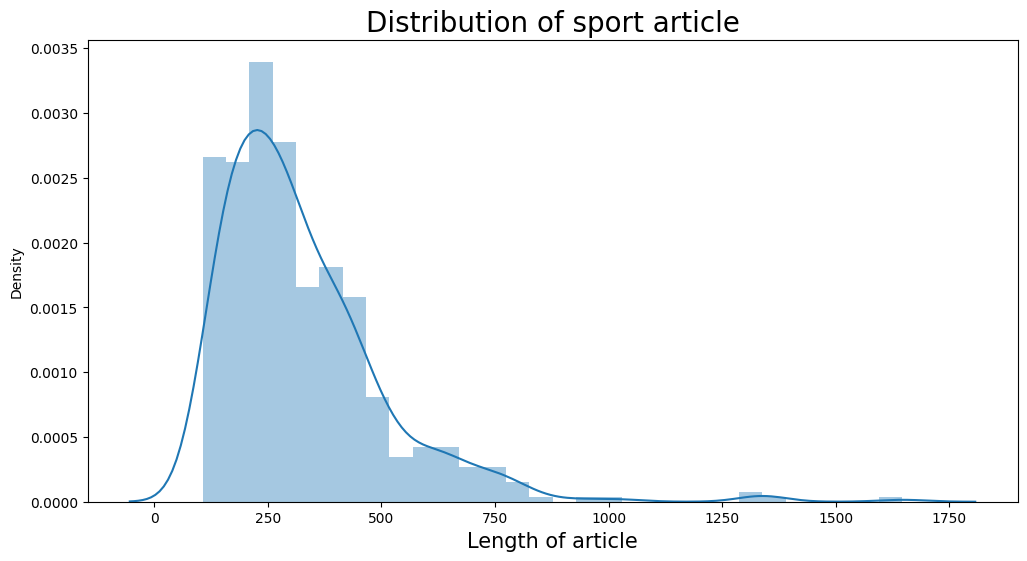

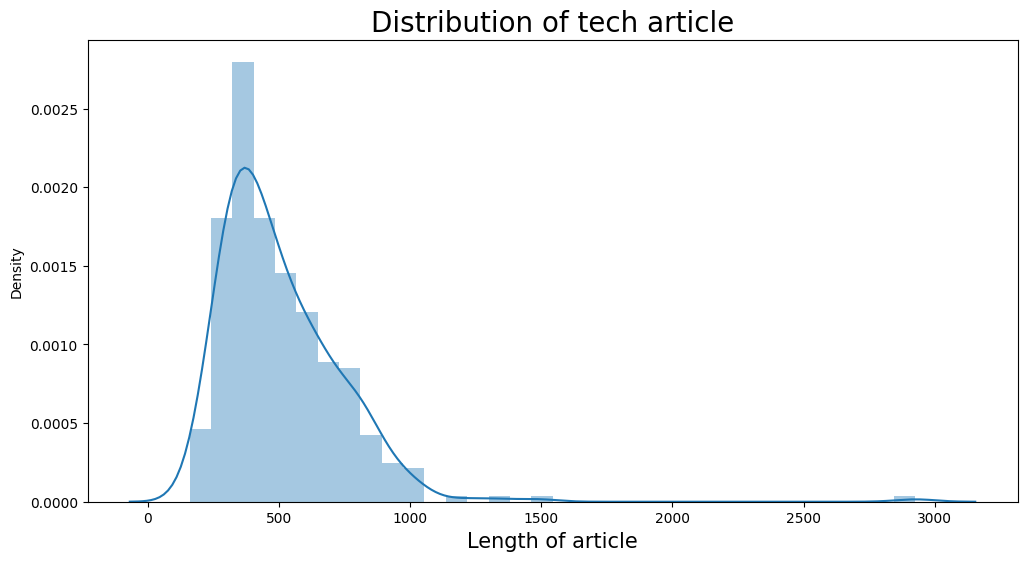

In [ ]:
#Distribution of different types of articles
types_article=list(df['type'].unique())
for article in types_article:
  df_article=df[df['type']==article]
  plt.figure(figsize=(12,6))
  fig=sns.distplot(x=df_article['word_count'])
  fig.set_title(f'Distribution of {article} article',size=20)
  fig.set_xlabel('Length of article',size=15)

* Topics Business and Sports have more number of news articles in the dataset.
* Business has more aritlces of lesser word-counts.
* Politics and Entertainment articles are bigger than any other topic.
* The curve shows most of the articles are of length 500 words approx.


### Data preprocessing

In [ ]:
#copying the original data
corpus_df=df.copy(deep=True)

In [ ]:
#First observation
obs=df['news'][0]
obs

'b\'Industrial output falls in Japan\\n\\nJapanese industrial output fell in October while unemployment rose, casting further doubt on the strength of the country\\\'s economic recovery.\\n\\nProduction dropped 1.6% in October, reflecting a decline in exports, while unemployment levels edged up 0.1% to 4.7%, slightly higher than forecast. The economy has grown for six quarters but growth slowed dramatically in the last quarter amid weaker global demand. Japan\\\'s government remains optimistic due to strong domestic demand.\\n\\nAnalysts had been forecasting a 0.1% rise in month on month industrial output.\\n\\nAccording to figures from the Ministry of Economy, Trade and Industry (METI), the decline was led by a fall in demand for electronic parts for mobile phones and digital televisions. Although inventories fell 0.7% month on month, they were 36% higher than a year ago. "It\\\'s a sign that the economy\\\'s adjustment phase is stronger than expected," said Takashi Yamanaka, an econo

* The above article has <b>punctuation, numericals , special characters and new line character </b>.  These are needed to be cleaned for further processing

In [ ]:
#Data preprocessing on a random observation
#Removal of newline character
obs=obs.replace('\\n'," ")

#Removal of all the punctuations,special character, numbers
obs=re.sub("[^a-zA-Z]"," ",obs)

#conversion to lower case
obs=obs.lower()

#removal of additional whitespace
obs=re.sub(r'\s+'," ",obs)

#After basic cleaning
obs


'b industrial output falls in japan japanese industrial output fell in october while unemployment rose casting further doubt on the strength of the country s economic recovery production dropped in october reflecting a decline in exports while unemployment levels edged up to slightly higher than forecast the economy has grown for six quarters but growth slowed dramatically in the last quarter amid weaker global demand japan s government remains optimistic due to strong domestic demand analysts had been forecasting a rise in month on month industrial output according to figures from the ministry of economy trade and industry meti the decline was led by a fall in demand for electronic parts for mobile phones and digital televisions although inventories fell month on month they were higher than a year ago it s a sign that the economy s adjustment phase is stronger than expected said takashi yamanaka an economist with ufj bank japan downgraded its overall economic assessment earlier this m

A basic cleaning has been performed . Now Applying this one whole data

In [ ]:
#Function to perform cleaning or preprocessing of articles
def cleaning(text):
  cleaned_text = text.replace('\\n'," ")                              # removal of new line symbol \n

  cleaned_text = re.sub("[^a-zA-Z]"," ",cleaned_text)                 # removal of all the punctuations,special character, numbers

  cleaned_text = cleaned_text.lower()                                 # converting to lower case

  cleaned_text = re.sub(r'\s+'," ",cleaned_text)                      # Removal of additional white space

  return cleaned_text

In [ ]:
#Applying basic cleaning to whole data
corpus_df['news']=corpus_df['news'].apply(cleaning)

In [ ]:
#Word Count after basic cleaning
corpus_df['wc_after_cleaning']=corpus_df['news'].apply(word_count)

In [ ]:
corpus_df.head()

,news,type,length,word_count,wc_after_cleaning
0,b industrial output falls in japan japanese in...,business,1847,288,289
1,b umbro profits lifted by euro uk sportswear f...,business,1377,226,225
2,b chinese wine tempts italy s illva italy s il...,business,1268,207,208
3,b deutsche telekom sees mobile gain german tel...,business,949,150,161
4,b japanese mogul arrested for fraud one of jap...,business,2483,415,427


#### Lemmatization

In [ ]:
#Lemmatization
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
def lemmatize_word(text):
    word_list = word_tokenize(text)
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    return ' '.join(word_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#Applying lemmatization
corpus_df['news']=corpus_df['news'].apply(lemmatize_word)

[Text(0.5, 1.0, 'Top 15 most frequent words in the corpus')]

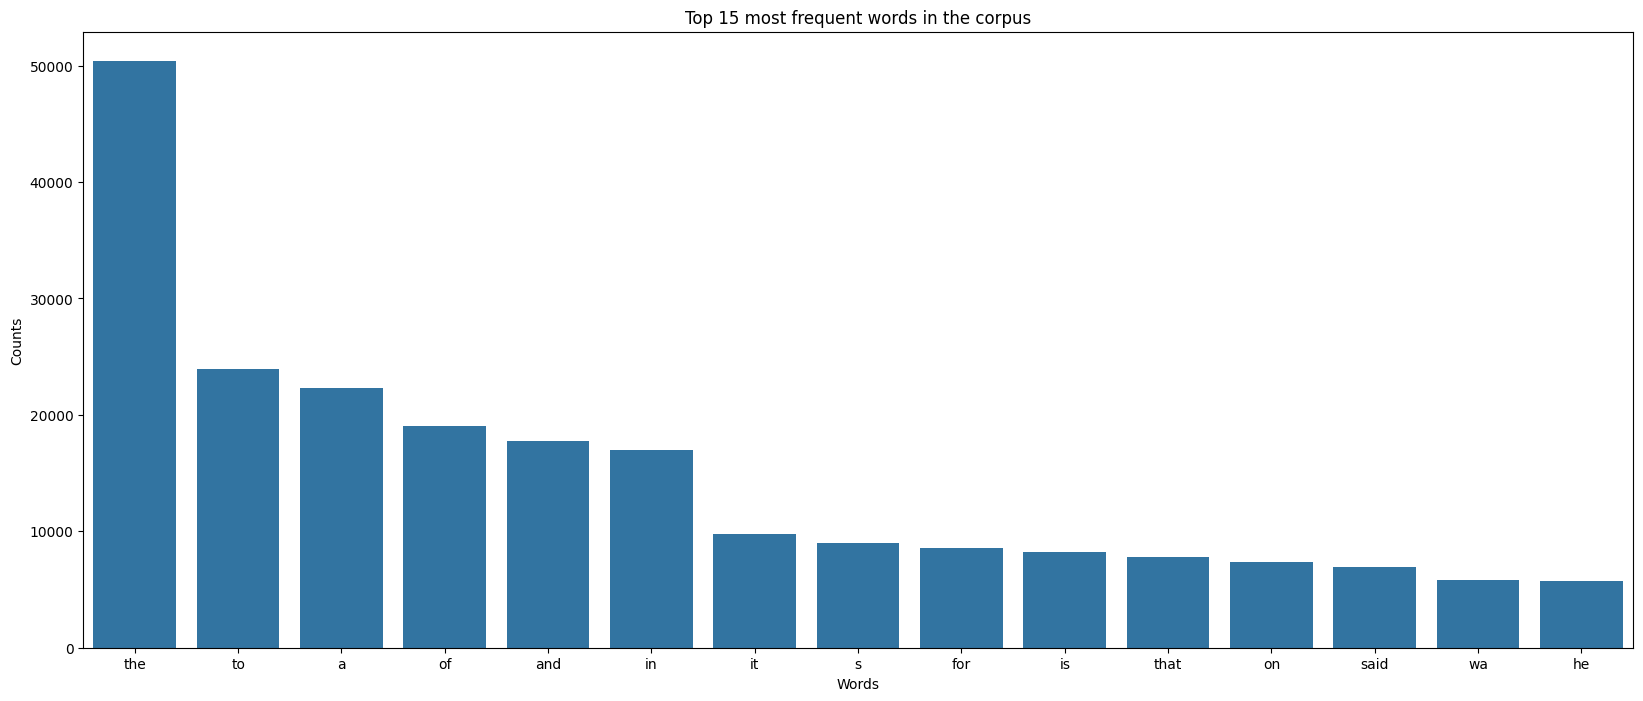

In [ ]:
#Top 15 most frequent words in the corpus
Top_15_freq = pd.Series(' '.join(corpus_df['news']).split()).value_counts()[:15]
top15=pd.DataFrame()
top15['Words']= list(Top_15_freq.index)
top15['Counts']=list(Top_15_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top15,ax=ax).set(title='Top 15 most frequent words in the corpus')

* The graph shows that stopwords are most frequent in the whole dataset. So these stopwords need to be removed.
*Also the short length (< 3) words are most frequent.

In [ ]:
#Removing short length words ( length less than 3)
def short_length(text):
  return (' '.join([wds for wds in text.split() if len(wds)>2]))

corpus_df['news']=corpus_df['news'].apply(short_length)


In [ ]:
#Word count after removal of short length
corpus_df['wc_rem_short_len']=corpus_df['news'].apply(word_count)

In [ ]:
corpus_df.head()

,news,type,length,word_count,wc_after_cleaning,wc_rem_short_len
0,industrial output fall japan japanese industri...,business,1847,288,289,231
1,umbro profit lifted euro sportswear firm umbro...,business,1377,226,225,169
2,chinese wine tempts italy illva italy illva sa...,business,1268,207,208,159
3,deutsche telekom see mobile gain german teleco...,business,949,150,161,116
4,japanese mogul arrested for fraud one japan be...,business,2483,415,427,316


#### Removing Stopwords

In [ ]:
#Stopwords
# list of stopwords from nltk
stopwords_nltk = list(stopwords.words('english'))

# list of stopwords from spacy
sp = spacy.load('en_core_web_sm')
stopwords_spacy = list(sp.Defaults.stop_words)

# list of stopwords from gensim
stopwords_gensim = list(gensim.parsing.preprocessing.STOPWORDS)

# unique stopwords from all stopwords
all_stopwords = []
all_stopwords.extend(stopwords_nltk)
all_stopwords.extend(stopwords_spacy)
all_stopwords.extend(stopwords_gensim)

# all unique stop words
all_stopwords = list(set(all_stopwords))

def stop_words(text):
  text = [wd.lower() for wd in text.split() if wd.lower() not in all_stopwords]
  return " ".join(text)

In [ ]:
len(all_stopwords)

412

In [ ]:
#Removal of Stopwords
corpus_df['news']=corpus_df['news'].apply(stop_words)

In [ ]:
# word count after removing the stopwords
corpus_df['after_stop']=corpus_df['news'].apply(word_count)

In [ ]:
corpus_df.head()

,news,type,length,word_count,wc_after_cleaning,wc_rem_short_len,after_stop
0,industrial output fall japan japanese industri...,business,1847,288,289,231,157
1,umbro profit lifted euro sportswear firm umbro...,business,1377,226,225,169,123
2,chinese wine tempts italy illva italy illva sa...,business,1268,207,208,159,112
3,deutsche telekom mobile gain german telecom fi...,business,949,150,161,116,87
4,japanese mogul arrested fraud japan best known...,business,2483,415,427,316,198


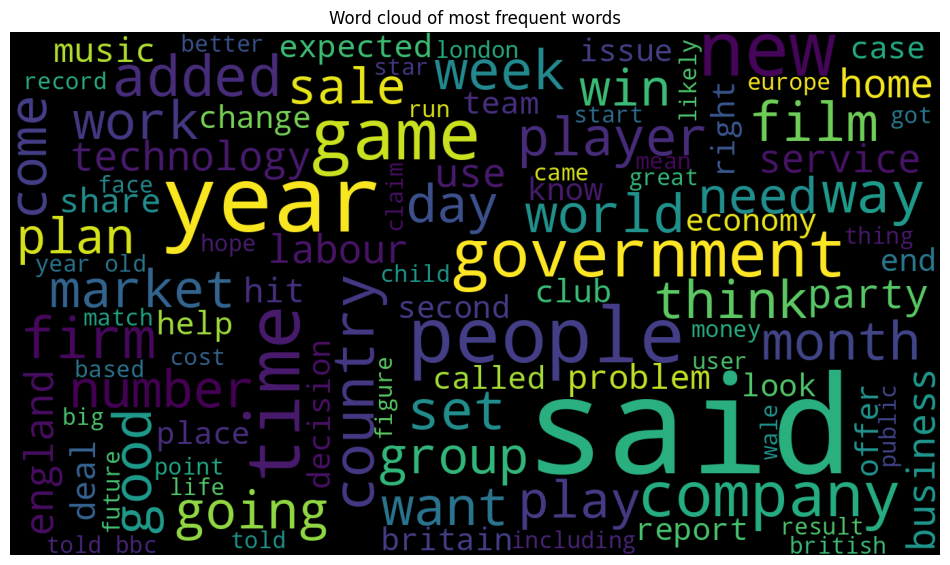

In [ ]:
# Cloud Words plot for displaying most frequent words in the data
freq_words = ','.join(list(corpus_df['news'].values))

wordcloud = WordCloud(width=1366, height=768, random_state=21,max_words=100 ,max_font_size=200,background_color='black').generate(freq_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.title('Word cloud of most frequent words')
plt.axis('off')
plt.show()

In [ ]:
#removal of non-contextual words
add_stopwords= ['said','told','called','use','know','came','based','way','added','including','got']

In [ ]:
#Function to remove additional stopwords
def remove_add_stopwords(text):
  text = [wd.lower() for wd in text.split() if wd.lower() not in add_stopwords]
  return " ".join(text)


In [ ]:
#Removing addtional stopwords according to use case
corpus_df['news']=corpus_df['news'].apply(remove_add_stopwords)

In [ ]:
# word count after removing the additional stopwords
corpus_df['wc_rem_stopword']=corpus_df['news'].apply(word_count)

In [ ]:
corpus_df.head()

,news,type,length,word_count,wc_after_cleaning,wc_rem_short_len,after_stop,wc_rem_stopword
0,industrial output fall japan japanese industri...,business,1847,288,289,231,157,154
1,umbro profit lifted euro sportswear firm umbro...,business,1377,226,225,169,123,117
2,chinese wine tempts italy illva italy illva sa...,business,1268,207,208,159,112,109
3,deutsche telekom mobile gain german telecom fi...,business,949,150,161,116,87,83
4,japanese mogul arrested fraud japan best known...,business,2483,415,427,316,198,194


[Text(0.5, 1.0, 'Top 15 most frequent words in the corpus After stopword removal')]

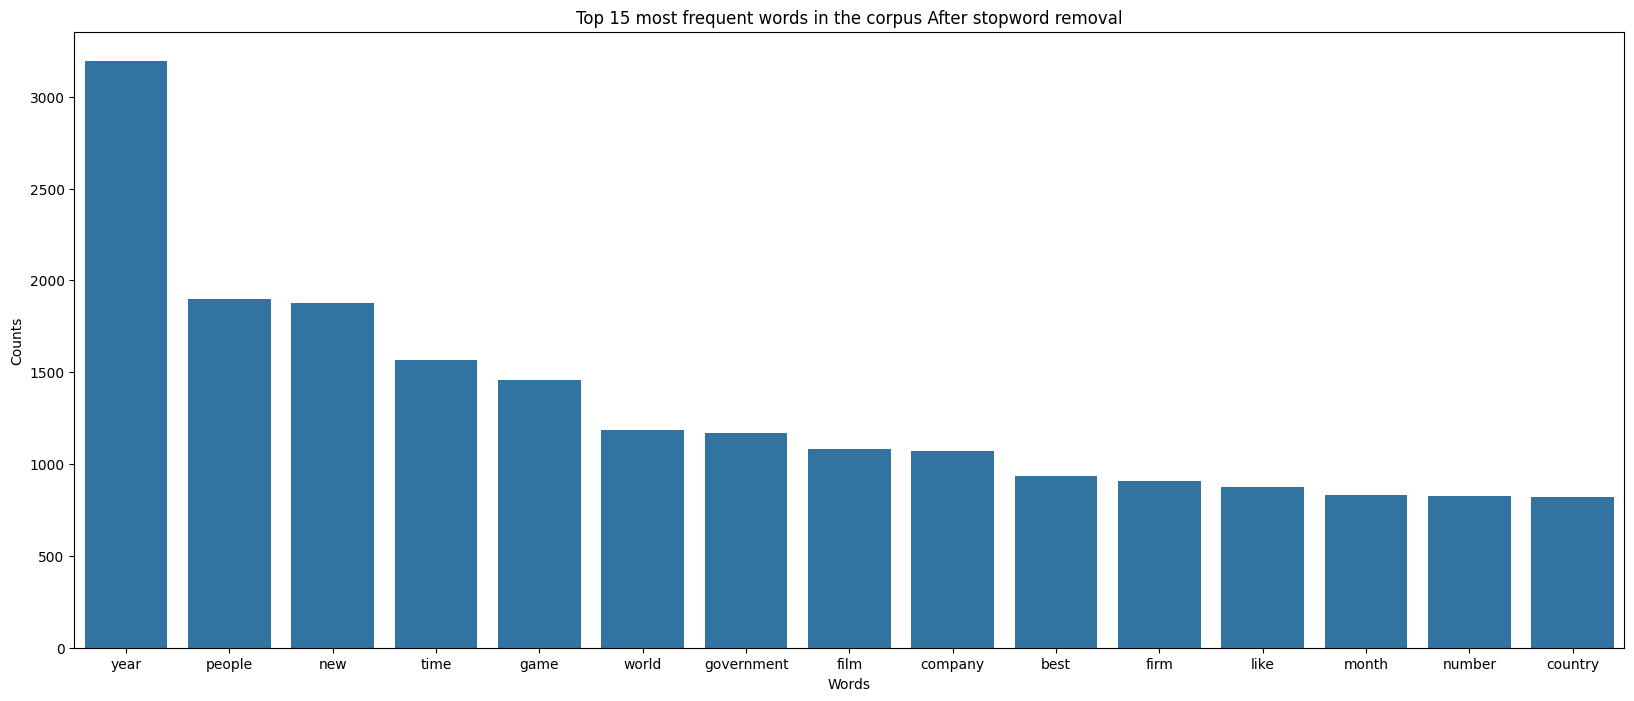

In [ ]:
#Top 15 most frequent words in the corpus After stopword removal
Top_15_freq = pd.Series(' '.join(corpus_df['news']).split()).value_counts()[:15]
top15=pd.DataFrame()
top15['Words']= list(Top_15_freq.index)
top15['Counts']=list(Top_15_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top15,ax=ax).set(title='Top 15 most frequent words in the corpus After stopword removal')

* After removing stopwords, the frequencies of contexual words are more apparent.

#### Visualization of top 20 bi-gram & tri-gram

In [ ]:
def get_top_n_gram(corpus, ngram, n=20):

    '''
    This functions takes entire corpus and returns list of tuple in  pair words and number of its occurence.
    '''
    # creates instance of count vectorizer for n-grams
    vec = CountVectorizer(ngram_range=(ngram,ngram)).fit(corpus)

    # returns sparse matrix of index as documents and columns as Bow as features
    bag_of_words = vec.transform(corpus)

    # returns 2D array with count of features in corpus
    sum_words = bag_of_words.sum(axis=0)

    # returns list of tuples with text,counts pair
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # sort the list of tuples by its number of occurence
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    # returns list of tuples top n words
    return words_freq[:n]

[Text(0.5, 1.0, 'Top 20 bigram words')]

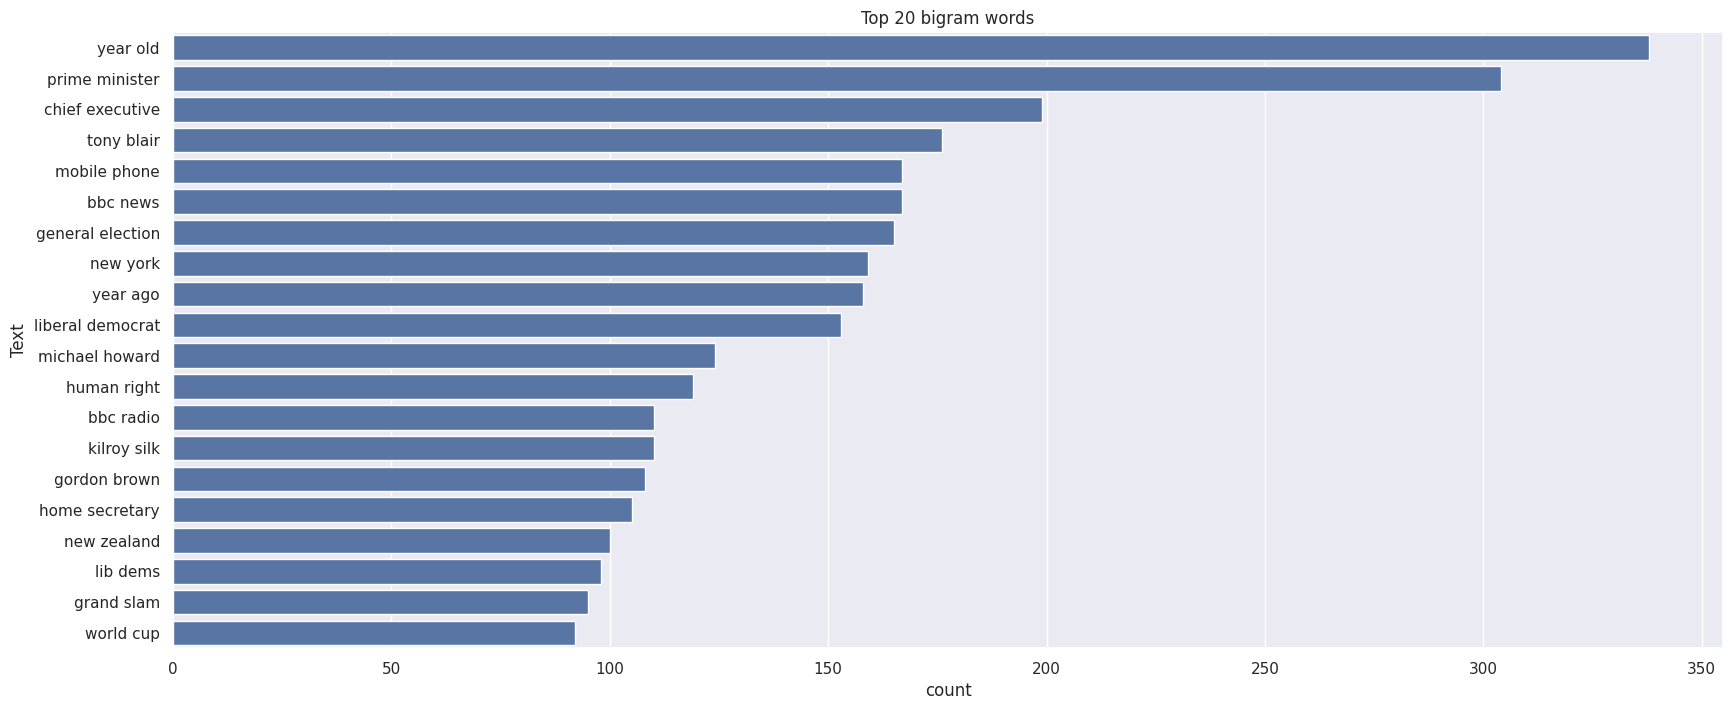

In [ ]:
# get top 20 bigram words using function
common_words = get_top_n_gram(corpus_df['news'],ngram=2)

# creates dataframe from list of tuples
df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

# plot top 20 words
sns.set(font_scale = 1)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(y= 'Text',x = 'count',data = df1,ax=ax).set(title='Top 20 bigram words')

[Text(0.5, 1.0, 'Top 20 trigram words')]

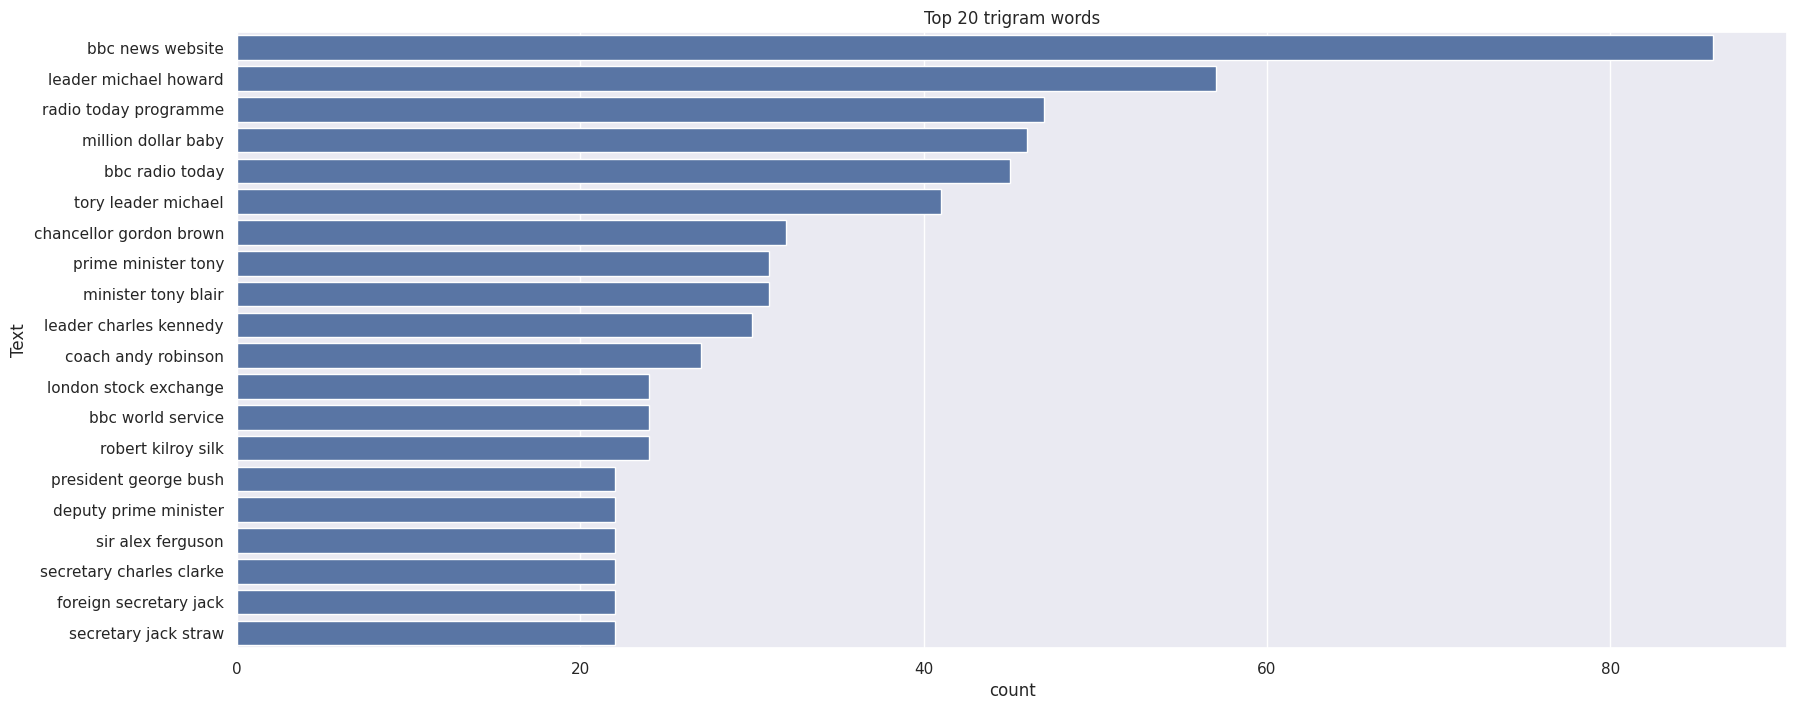

In [ ]:
# get top 20 trigram words using function
common_words = get_top_n_gram(corpus_df['news'],ngram=3)

# creates dataframe from list of tuples
df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

# plot top 20 words
sns.set(font_scale = 1)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(y= 'Text',x = 'count',data = df2,ax=ax).set(title='Top 20 trigram words')

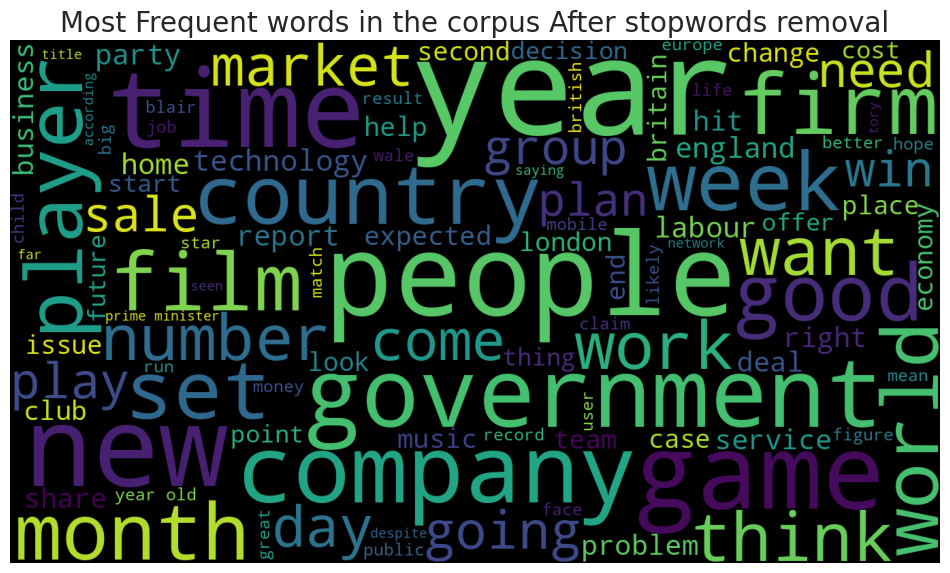

In [ ]:
#Most Frequent words in the corpus
freq_words = ','.join(list(corpus_df['news'].values))

wordcloud = WordCloud(width=1366, height=768, random_state=42,max_words=100 ,max_font_size=200,background_color='black').generate(freq_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.title('Most Frequent words in the corpus After stopwords removal',size=20)
plt.axis('off')
plt.show()

In [ ]:
#Data reduction
after_preprocess=corpus_df['wc_rem_stopword'].sum()
after_preprocess

data_reduce=(after_preprocess/Total_words)*100
data_reduce

48.56823185834349

* Almost 50% of unneccessary data has been removed.

#### LDA

In [ ]:
#Tf-Idf vectoriser
vectorizer = TfidfVectorizer(min_df = 0.03)
document_term_matrix = vectorizer.fit_transform(corpus_df['news'])

In [ ]:
#Shape of document term matrix
document_term_matrix.shape

(2127, 947)

In [ ]:
# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(5,10))}

# LDA model
lda_model = GridSearchCV(LatentDirichletAllocation(),param_grid=grid_params)
lda_model.fit(document_term_matrix)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(document_term_matrix))

Best LDA model's params {'n_components': 5}
Best log likelihood Score for the LDA model -23982.126430496566
LDA model Perplexity on train data 1432.953303690792


In [ ]:
# LDA model fitting for best parameter
lda= LatentDirichletAllocation(n_components=5, max_iter=1000, random_state=42, n_jobs=-1)
lda.fit(document_term_matrix)

LatentDirichletAllocation(max_iter=1000, n_components=5, n_jobs=-1,
                          random_state=42)

In [ ]:
# LDA model
top_lda=lda.fit_transform(document_term_matrix)

print(top_lda.shape)
print(top_lda)

(2127, 5)
[[0.02502712 0.89995787 0.0250538  0.0247607  0.02520051]
 [0.02740415 0.68869896 0.02727143 0.02694961 0.22967585]
 [0.03390211 0.86510428 0.03359278 0.03340885 0.03399198]
 ...
 [0.03432232 0.8644525  0.03393445 0.03335909 0.03393164]
 [0.030244   0.87987753 0.03001424 0.02959391 0.03027032]
 [0.0231689  0.90197692 0.02387213 0.02251541 0.02846665]]


In [103]:
score_df = pd.DataFrame(top_lda, columns = ['politics', 'business', 'entertainment', 'tech', 'sports'])
score_df

,politics,business,entertainment,tech,sports
0,0.025027,0.899958,0.025054,0.024761,0.025201
1,0.027404,0.688699,0.027271,0.026950,0.229676
2,0.033902,0.865104,0.033593,0.033409,0.033992
3,0.038131,0.847694,0.038100,0.037843,0.038232
4,0.026933,0.877258,0.026639,0.025977,0.043192
...,...,...,...,...,...
2122,0.024693,0.802780,0.120131,0.024016,0.028380
2123,0.029361,0.857304,0.029213,0.028720,0.055402
2124,0.034322,0.864452,0.033934,0.033359,0.033932
2125,0.030244,0.879878,0.030014,0.029594,0.030270


In [ ]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(top_lda[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  2.502712149510691 %
Topic  1 :  89.99578689976614 %
Topic  2 :  2.5053798301418952 %
Topic  3 :  2.4760703378503126 %
Topic  4 :  2.5200507827309546 %


* The first document is more belonging to the Topic 1 (business).

In [ ]:
# composition of doc 1520 for eg
print("Document 1520: ")
for i,topic in enumerate(top_lda[1520]):
  print("Topic ",i,": ",topic*100,"%")

Document 1510: 
Topic  0 :  2.84598903696695 %
Topic  1 :  3.8935980211530796 %
Topic  2 :  2.716025372840616 %
Topic  3 :  2.667707251147884 %
Topic  4 :  87.87668031789147 %


* The 1520th document is more belonging to the Topic 4 (sports).

In [83]:
# most important words for each topic
vocab = vectorizer.get_feature_names_out()

In [84]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def word_cloud_lda(index):
  imp_words_topic=""
  comp=lda.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400,max_font_size=100).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

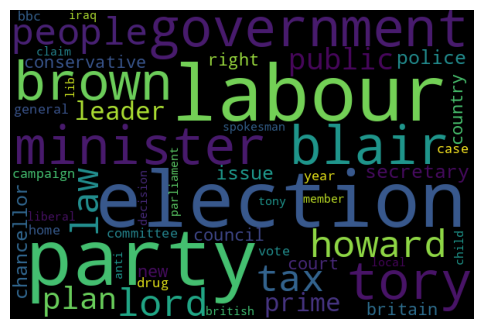

In [85]:
#Word Cloud for each topic
word_cloud_lda(0)

* Politics

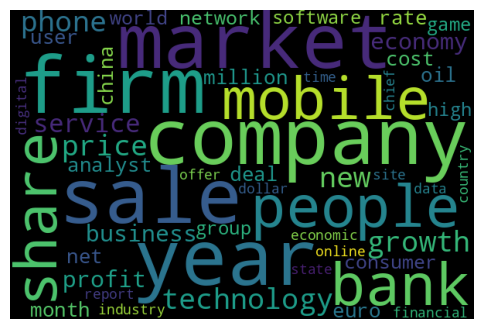

In [86]:
word_cloud_lda(1)

* Business

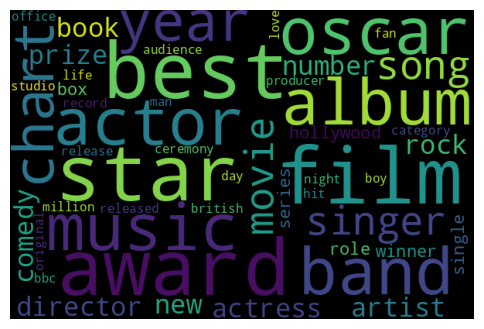

In [87]:
word_cloud_lda(2)

* Entertainment

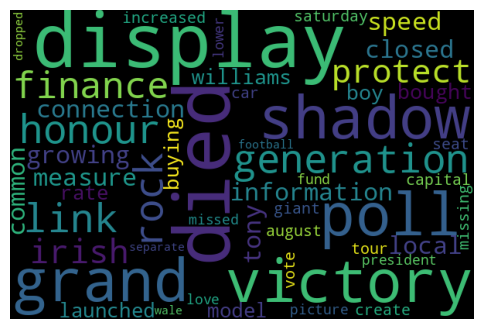

In [88]:
word_cloud_lda(3)

* Technology

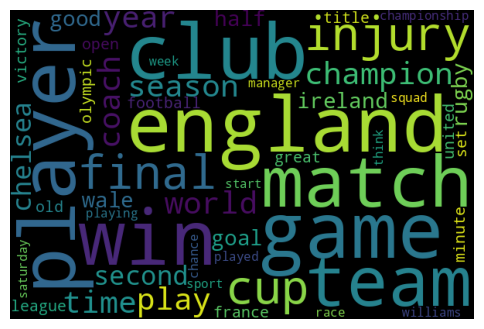

In [89]:
word_cloud_lda(4)

* Sports

#### LSA

In [90]:
# create svd instance
svd_model = TruncatedSVD(n_components=5,random_state=42,algorithm='randomized')

# fit model to data
svd_model.fit(document_term_matrix)

tsvd_mat=svd_model.transform(document_term_matrix)

In [91]:
#Shape of truncated SVD
tsvd_mat.shape

(2127, 5)

In [101]:
#Using t-sne for transformation
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(tsvd_mat)
tsne_mat

array([[ 50.44721  ,  18.398159 ],
       [ 46.81925  ,  21.664019 ],
       [ 40.619373 ,  16.642164 ],
       ...,
       [-10.223589 ,  49.549885 ],
       [  6.2274065,  27.970499 ],
       [-12.491887 ,  40.95447  ]], dtype=float32)

In [102]:
#Scatter plot of the topics using the t-sne in LSA
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=corpus_df['type'])

* The points of technology  & business clusters are scattered at different areas.

In [95]:
# Function to generate word cloud for each topic
def word_cloud_lsa(index):
  imp_words_topic=""
  comp=svd_model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=800, height=500).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

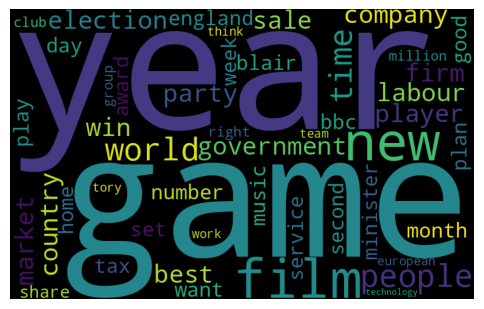

In [96]:
#Word Cloud for each topic using LSA
word_cloud_lsa(0)

* Sports

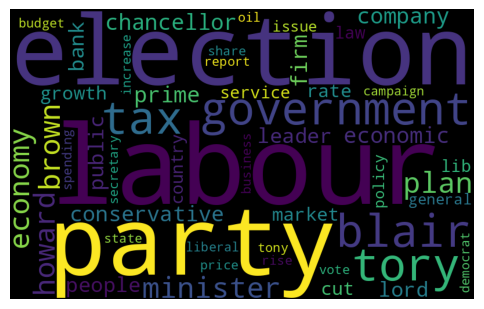

In [97]:
word_cloud_lsa(1)

* Politics

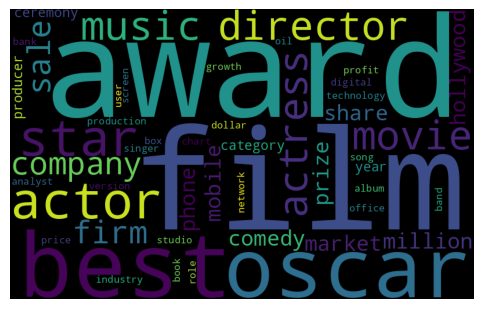

In [98]:
word_cloud_lsa(2)

* Entertainment

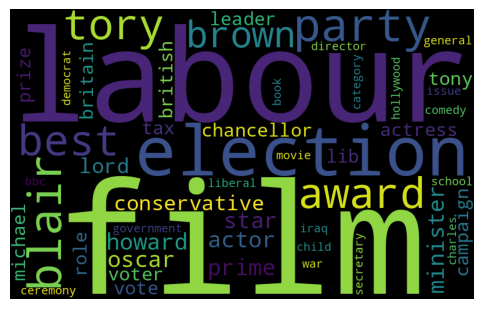

In [99]:
word_cloud_lsa(3)

* Business ; but not clear as in the scatterplot the cluster are not differentaited well.

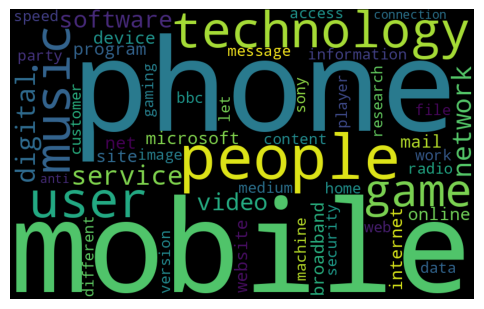

In [100]:
word_cloud_lsa(4)

* technology

## **Conclusion**

### * There are 5 different topic present in the articles.
### * LDA and LSA are implemented to find the hidden topics.
### * LDA performs well & shows 5 different clusters present in the Corpus.
### * LSA also shows the 5 different clusters.
